# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import libraries</p>


In [27]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [28]:
df=pd.read_csv(r"/content/Supplement_Sales_Weekly_Expanded.csv")
df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,1/6/2020,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,1/6/2020,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,1/6/2020,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,1/6/2020,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,1/6/2020,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [29]:
df.tail()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
294,5/11/2020,Creatine,Performance,127,29.47,3742.69,0.14,4,Canada,iHerb
295,5/11/2020,Zinc,Mineral,127,13.71,1741.17,0.09,2,USA,Walmart
296,5/11/2020,Collagen Peptides,Protein,152,21.01,3193.52,0.09,1,Canada,iHerb
297,5/11/2020,Magnesium,Mineral,127,33.21,4217.67,0.18,2,USA,iHerb
298,5/11/2020,Ashwagandha,Herbal,158,20.88,3299.04,0.17,1,Canada,Amazon


# <p style="padding:10px;background-color:green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">EDA</p>


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            299 non-null    object 
 1   Product Name    299 non-null    object 
 2   Category        299 non-null    object 
 3   Units Sold      299 non-null    int64  
 4   Price           299 non-null    float64
 5   Revenue         299 non-null    float64
 6   Discount        299 non-null    float64
 7   Units Returned  299 non-null    int64  
 8   Location        299 non-null    object 
 9   Platform        299 non-null    object 
dtypes: float64(3), int64(2), object(5)
memory usage: 23.5+ KB


In [31]:
df.isna().sum()

,0
Date,0
Product Name,0
Category,0
Units Sold,0
Price,0
Revenue,0
Discount,0
Units Returned,0
Location,0
Platform,0


In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Units Sold,299.0,149.608696,12.892068,116.00,141.000,150.00,158.000,188.00
Price,299.0,33.942140,14.137119,10.16,21.385,33.82,45.555,59.64
Revenue,299.0,5068.577692,2138.036206,1358.08,3183.640,5042.10,6672.825,9894.00
Discount,299.0,0.123846,0.073851,0.00,0.060,0.13,0.190,0.25
Units Returned,299.0,1.494983,1.121394,0.00,1.000,1.00,2.000,5.00


In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
15,2020-01-06,Electrolyte Powder,Hydration,154,35.92,5531.68,0.04,2,USA,Amazon
14,2020-01-06,Iron Supplement,Mineral,149,42.97,6402.53,0.22,2,Canada,iHerb
13,2020-01-06,Green Tea Extract,Fat Burner,143,31.88,4558.84,0.06,3,UK,Walmart
12,2020-01-06,Biotin,Vitamin,159,28.79,4577.61,0.10,1,UK,iHerb


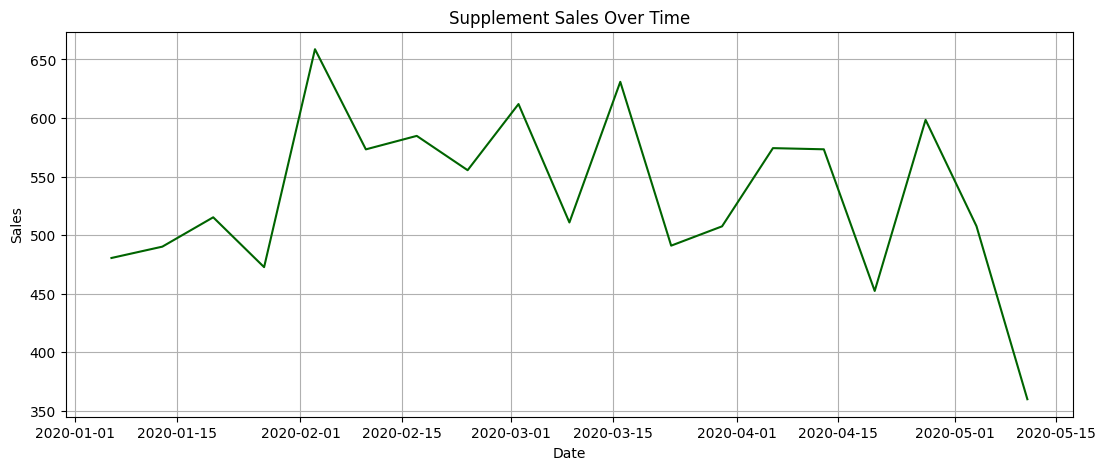

In [34]:
plt.figure(figsize=(13, 5))
df_price=df.groupby('Date')['Price'].sum().reset_index()
sns.lineplot(x='Date',y='Price',data=df_price,color='darkgreen')
plt.title('Supplement Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


In [35]:
top_products = df.groupby('Product Name')['Revenue'].sum().sort_values(ascending=False)
top_products

,Revenue
Product Name,
Pre-Workout,113682.26
Creatine,107697.75
Zinc,103731.39
Collagen Peptides,103204.72
Fish Oil,97642.35
Whey Protein,95855.15
Vitamin C,94429.75
Melatonin,93888.71
Ashwagandha,92596.91


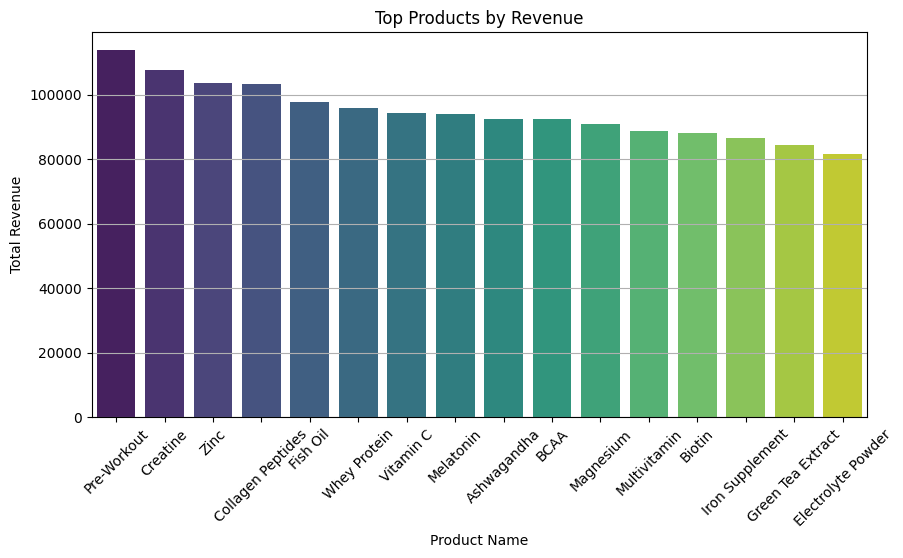

In [36]:
plt.figure(figsize=(10, 5))

idx=top_products.index
vals=top_products.values
sns.barplot(x=idx,y=vals,palette='viridis')

plt.title("Top Products by Revenue")
plt.xticks(rotation=45)
plt.ylabel("Total Revenue")
plt.grid(axis='y')
plt.show()

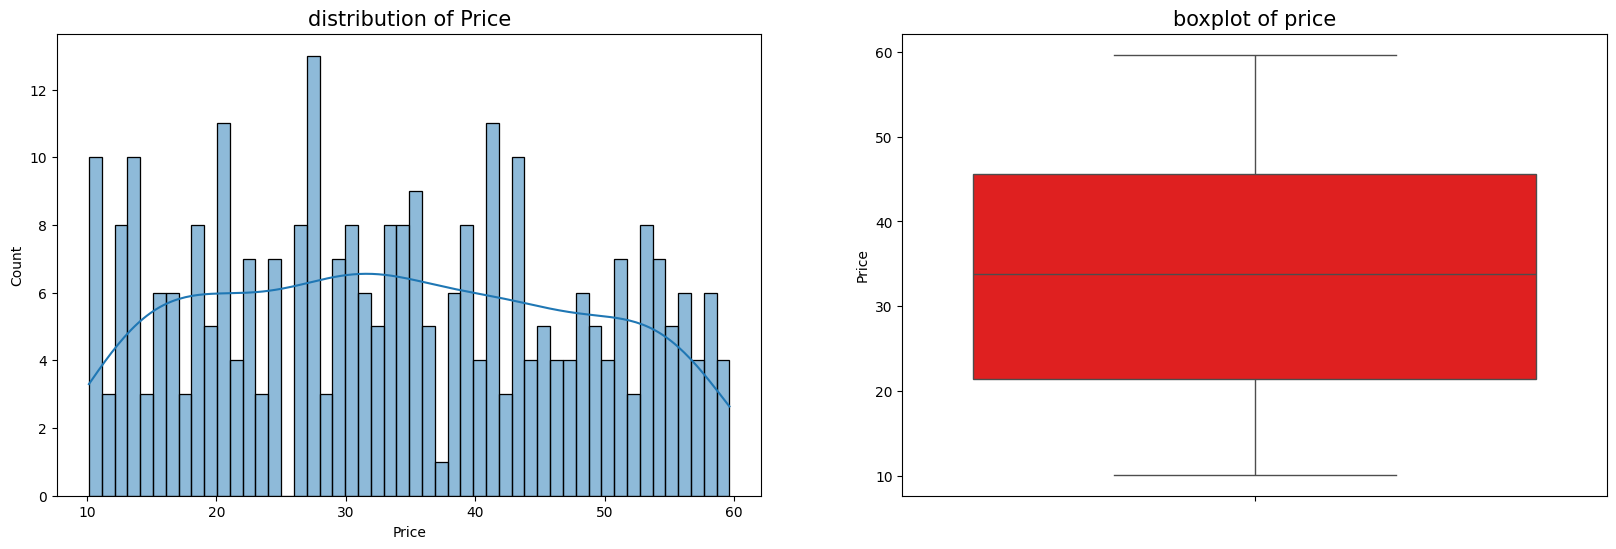

In [37]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.histplot(x=df['Price'],bins=50,kde=True)
plt.title('distribution of Price',fontsize=15)

plt.subplot(1,2,2)
sns.boxplot(y=df['Price'],color='red')
plt.title('boxplot of price',fontsize=15)

plt.show()

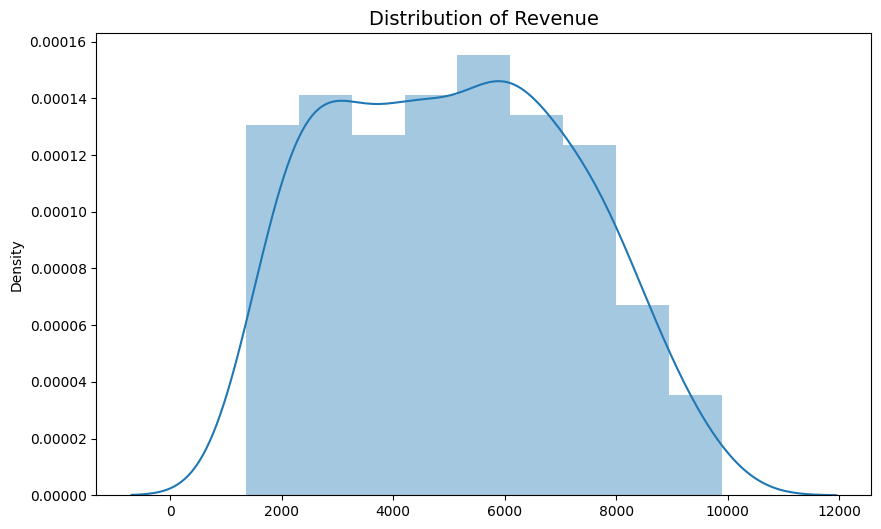

In [38]:
plt.figure(figsize=(10,6))
sns.distplot(x=df['Revenue'])
plt.title('Distribution of Revenue', fontsize=14)
plt.show()

In [39]:
df['Category'].value_counts().sort_values()


,count
Category,
Hydration,18
Fat Burner,18
Sleep Aid,18
Amino Acid,19
Omega,19
Herbal,19
Performance,38
Protein,38
Mineral,56


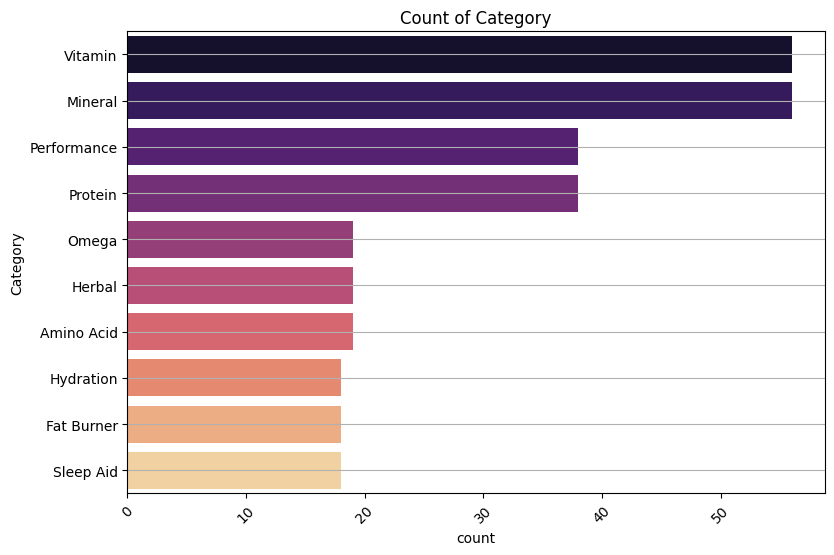

In [40]:
plt.figure(figsize=(9,6))
sns.countplot(y=df['Category']
              ,palette='magma',
              order=df['Category'].value_counts().index

             )
plt.xticks(rotation=45)
plt.title('Count of Category')
plt.grid(True,axis='y')

<Axes: xlabel='Units Sold', ylabel='Revenue'>

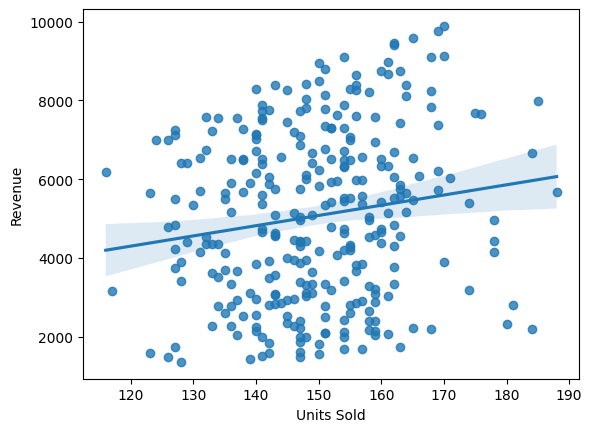

In [41]:
sns.regplot(x='Units Sold',y='Revenue',data=df)

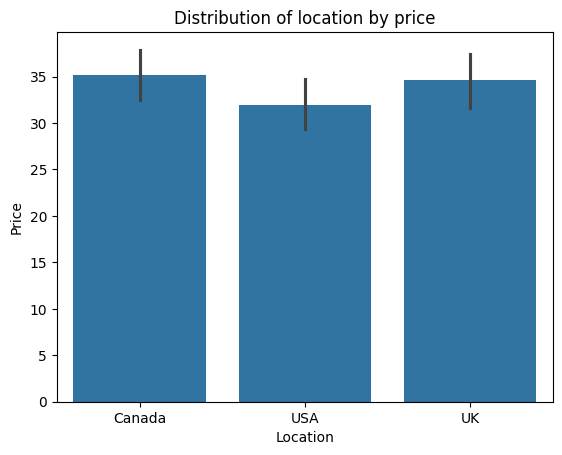

In [42]:
sns.barplot(x='Location',y='Price',data=df)
plt.title("Distribution of location by price")
plt.show()

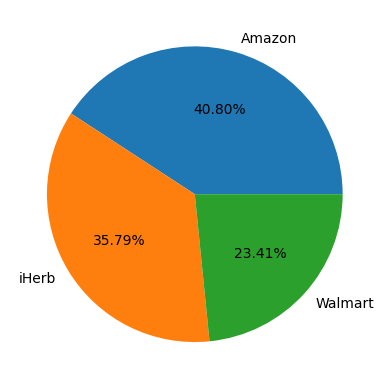

In [43]:
# pie plot
df['Platform'].value_counts()
plt.pie(df['Platform'].value_counts().values,
        labels=df['Platform'].value_counts().index,
        autopct="%.2f%%"
)
plt.show()

# ` Time Series`

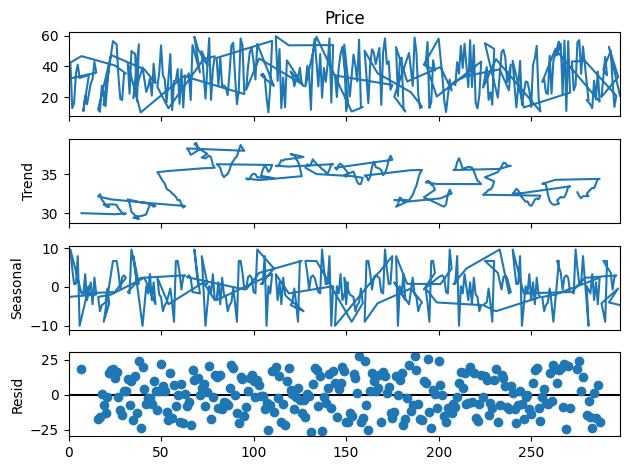

In [44]:
# Step 4: Decompose the time series
result = seasonal_decompose(df['Price'], model='additive', period=30)  # assume monthly data
result.plot()
plt.show()

In [45]:
# Step 5: Fit ARIMA model
model = ARIMA(df['Price'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  299
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1215.030
Date:                Sat, 17 May 2025   AIC                           2436.060
Time:                        08:18:22   BIC                           2447.151
Sample:                             0   HQIC                          2440.500
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0071      0.056      0.125      0.900      -0.103       0.118
ma.L1         -0.9999      1.333     -0.750      0.453      -3.613       1.613
sigma2       199.8669    265.975      0.751      0.4

In [46]:
# Step 6: Forecast next 30 days
forecast = model_fit.forecast(steps=30)
forecast

,predicted_mean
299,33.849423
300,33.941098
301,33.941746
302,33.941751
303,33.941751
304,33.941751
305,33.941751
306,33.941751
307,33.941751
308,33.941751


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Split Data</p>


In [47]:
#split data to train - test - valid
X = df.drop(columns='Revenue',axis=1)
y = df['Revenue']

X_train_full,X_test,y_train_full,y_test=train_test_split(X,y,test_size=.2,random_state=42)

X_train,X_valid,y_train,y_valid=train_test_split(X_train_full,y_train_full , test_size=.2,random_state=42)

print(X_train.shape)
print(y_train.shape)
print("===========")
print(X_valid.shape)
print(y_valid.shape)
print("===========")
print(X_test.shape)
print(y_test.shape)

(191, 9)
(191,)
(48, 9)
(48,)
(60, 9)
(60,)


In [48]:
# pipeline

num_col=[col for col in X.columns if df[col].dtype in ['int64','float64']]
cat_col=[col for col in X.columns if df[col].dtype not in ['int64','float64']]

# Numerical pipeline
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('labelencoder',OrdinalEncoder() )
])

# Combine all
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('categ', categ_pipeline, cat_col)
])

# Apply to all data
X_train_final = preprocessor.fit_transform(X_train)
X_valid_final=preprocessor.transform(X_valid)
X_test_final = preprocessor.transform(X_test)

In [49]:
# Check shapes again
print("X_train_final shape", X_train_final.shape)
print("y_train shape", y_train.shape)
print()
print("X_test_final shape", X_test_final.shape)
print("y_test shape", y_test.shape)
print()
print("X_valid_final shape", X_valid_final.shape)
print("y_valid shape", y_valid.shape)

X_train_final shape (191, 9)
y_train shape (191,)

X_test_final shape (60, 9)
y_test shape (60,)

X_valid_final shape (48, 9)
y_valid shape (48,)


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Build Models</p>


# 1) `lightgbm`

##  Core Parameters <a class="anchor" id="4.2"></a>



- **Task** : It specifies the task you want to perform on data. It may be either train or predict.

- **application** : This is the most important parameter and specifies the application of your model, whether it is a regression problem or classification problem. LightGBM will by default consider model as a regression model.

  - **regression** : for regression
  - **binary** : for binary classification
  - **multiclass** : for multiclass classification problem
  
  
- **boosting** : defines the type of algorithm you want to run, default=gdbt.

  - **gbdt** : traditional Gradient Boosting Decision Tree
  - **rf** : random forest
  - **dart** : Dropouts meet Multiple Additive Regression Trees
  - **goss** : Gradient-based One-Side Sampling
  
  
- **num_boost_round** : Number of boosting iterations, typically 100+

- **learning_rate** : This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…

- **num_leaves** : number of leaves in full tree, default: 31

- **device** : default: cpu, can also pass gpu

In [50]:
model_lgb = lgb.LGBMRegressor(
    boosting_type = 'gbdt',
    num_leaves = 31,
    max_depth= 7,
    learning_rate= 0.1,
    n_estimators = 150,
    random_state=42
)
model_lgb.fit(X_train_final, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 191, number of used features: 9
[LightGBM] [Info] Start training from score 5112.515971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(max_depth=7, n_estimators=150, random_state=42)

In [51]:
# Evaluation of training

y_train_pred = model_lgb.predict(X_train_final)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("Training MSE:", train_mse)
print("Training R² Score:", train_r2)

Training MSE: 8620.06490812347
Training R² Score: 0.9980925514901516


In [52]:
# Evaluation of testing

y_valid_pred = model_lgb.predict(X_valid_final)
test_mse = mean_squared_error(y_valid, y_valid_pred)
test_r2 = r2_score(y_valid, y_valid_pred)
print("Test MSE:", test_mse)
print("Test R² Score:", test_r2)

Test MSE: 40381.090715396414
Test R² Score: 0.9903428071692851


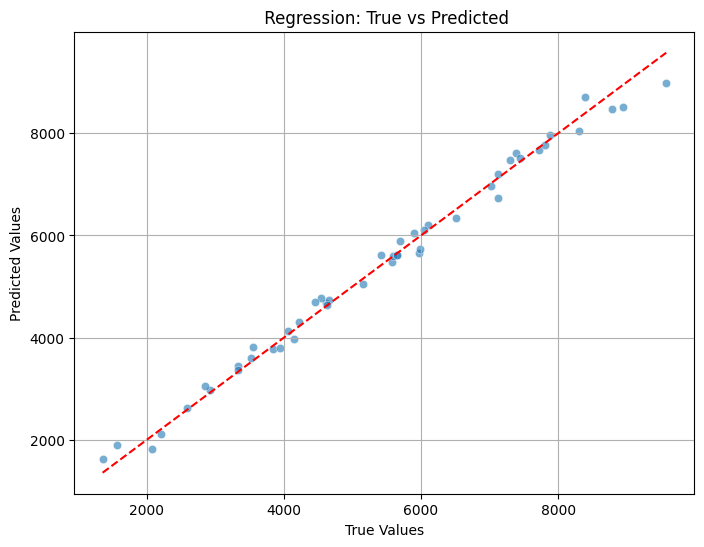

In [53]:
# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=y_valid_pred, alpha=0.6)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(" Regression: True vs Predicted")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # خط المثالية
plt.grid(True)
plt.show()

In [54]:
import joblib
joblib.dump(model_lgb, 'lgb_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']